In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Membaca file CSV dan mengabaikan kolom 'Unnamed'
df = pd.read_csv('data.csv', delimiter=';', usecols=lambda column: not column.startswith('Unnamed'))

# Tampilkan dataframe untuk memastikan kolom 'Unnamed' dihapus
print(df.head())

          Waktu  Nilai CIF (US$)
0  January 2023          2698188
1  January 2023         54631173
2  January 2023         42104589
3  January 2023        110054343
4  January 2023          7252795


In [ ]:
# Menggunakan PeriodIndex
df['Waktu'] = pd.to_datetime(df['Waktu'], format='%B %Y').dt.to_period('M')

# Set kolom 'Waktu' sebagai index
df = df.set_index('Waktu')

# Menampilkan DataFrame
print(df)

         Nilai CIF (US$)
Waktu                   
2023-01          2698188
2023-01         54631173
2023-01         42104589
2023-01        110054343
2023-01          7252795
...                  ...
2024-04         30245163
2024-04         48580250
2024-04           273585
2024-04         37462029
2024-04         56297799

[1568 rows x 1 columns]


<ipython-input-4-4c7c7fdfd50f>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df.index.to_timestamp(), y=df['Nilai CIF (US$)'], ci=None)  # ci=None removes shadow


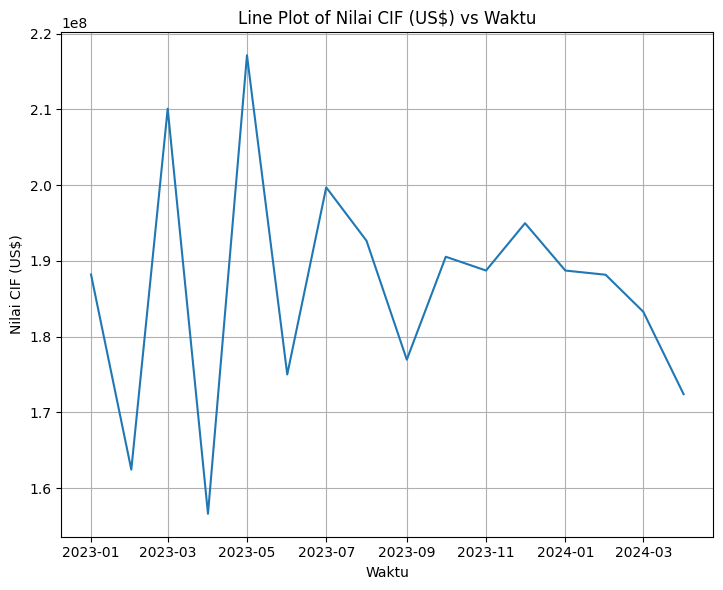

In [ ]:
# Plotting Scatter Plot and Line Plot of CIF values over time
plt.figure(figsize=(14, 6))

# Line plot without shadow
plt.subplot(1, 2, 2)
sns.lineplot(x=df.index.to_timestamp(), y=df['Nilai CIF (US$)'], ci=None)  # ci=None removes shadow
plt.title('Line Plot of Nilai CIF (US$) vs Waktu')
plt.xlabel('Waktu')
plt.ylabel('Nilai CIF (US$)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF Test to check for stationarity
adf_result = adfuller(df['Nilai CIF (US$)'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation of results
if adf_result[1] <= 0.05:
    print("Data CIF is stationary (p-value <= 0.05)")
else:
    print("Data CIF is not stationary (p-value > 0.05)")

ADF Statistic: -11.635558
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Data CIF is stationary (p-value <= 0.05)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Splitting Data
# Membagi data menjadi train dan test set (80% train, 20% test)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# 2. Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Nilai CIF (US$)']])
test_scaled = scaler.transform(test[['Nilai CIF (US$)']])

In [ ]:
# 3. Convert data to supervised learning format
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # time step bisa disesuaikan
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape data untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 4. Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0125 - val_loss: 0.0146
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0173 - val_loss: 0.0145
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0153 - val_loss: 0.0132
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0137 - val_l

In [ ]:
# 5. Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invers transformasi prediksi ke skala asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
# 7. Future Predictions
future_steps = 12  # Prediksi 12 bulan ke depan
last_test_data = test_scaled[-time_step:].reshape(1, time_step, 1)
predictions = []

for _ in range(future_steps):
    pred = model.predict(last_test_data)
    predictions.append(pred[0, 0])
    last_test_data = np.append(last_test_data[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
# Inverse transformasi ke skala asli
future_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

<ipython-input-21-2e53f94e4c18>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


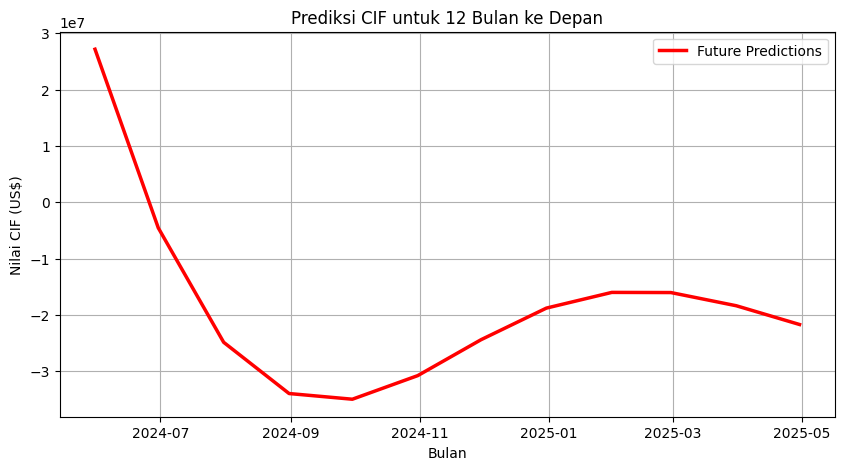

In [ ]:
# Plot future predictions with a thicker red line
future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', linewidth=2.5)  # Adjusted line thickness

# Titles and labels
plt.title('Prediksi CIF untuk 12 Bulan ke Depan')
plt.xlabel('Bulan')
plt.ylabel('Nilai CIF (US$)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Membagi sebagian data training untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Menambahkan callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Mulai dengan jumlah epochs yang besar
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0115 - val_loss: 0.0192
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0094 - val_loss: 0.0192
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0105 - val_loss: 0.0181
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0116 - val_loss: 0.0189
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0131 - val_loss: 0.0164
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0072 - val_loss: 0.0129
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0146 - val_loss: 0.0214
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0115 - val_loss: 0.0185
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0134 - val_loss: 0.0171
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0110 - val_loss: 0.0207
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/s

In [ ]:
# Melakukan prediksi pada data test
test_predict = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Menghitung metrik evaluasi
mae = mean_absolute_error(y_test, test_predict)
mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.03390614142242889
Mean Squared Error (MSE): 0.005594154903525098
Root Mean Squared Error (RMSE): 0.07479408334571057
